# Example of using SAMS to calibrate TYR
Notebook to explore the calibration of TYR method of `protons` in **implicit** solvent. Comparing **instant** protonation state exchanges with **NCMC** exchanges.

In [1]:
from __future__ import print_function
from simtk import unit, openmm
from simtk.openmm import app
from protons import AmberProtonDrive
from protons.calibration import SelfAdjustedMixtureSampling, AmberCalibrationSystem
import openmmtools
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

## Method 1. Calibration using `SelfAdjustedMixtureSampling` directly

In [2]:
def prepare_system(prmtop, inpcrd, cpin, pH = 7.0, platform='CPU', nsteps=0, implicit=True):
    """
    Function to prepare a system specified by AMBER topology files for a constant-ph calibration simulation with protons.
    Calibration is performed with self adjusted mixture sampling (SAMS).

    Parameters
    ----------
    prmtop: str
        the name of the AMBER prmtop file
    inpcrd: str
        the name of the AMBER inpcrd file
    cpin: str
        the name of the AMBER cpin file
    pH: float
        the pH at which the calibration will be performed
    platform: str
        OpenMM platform with which the simulation will be performed. Choices are 'CPU' or 'OpenCL'
    nsteps: int
        The number of NCMC steps to perform for proton creation/annihilation. If nstesp=0, instant exchanges will be done.
    implicit: bool
        Whether to calibrated in implicit or explicit solvent

    Return
    ------
    simulation: simtk.openmm.Simulation
        OpenMM simulation object
    driver: protons.AmberProtonDrive
        Driver for constant pH simulation
    sams_sampler: protons.SelfAdjustedMixtureSampling
        Wrapper for calibrating with SAMS
    integrator:  simtk.openmm.integrator
        Integrator for sampling the configuration of the system
    """
    # Loading system and initializing driver
    temperature = 300.0*unit.kelvin
    prmtop = app.AmberPrmtopFile(prmtop)
    inpcrd = app.AmberInpcrdFile(inpcrd)
    positions = inpcrd.getPositions()
    topology = prmtop.topology
    # Create system
    if implicit == True:
        system = prmtop.createSystem(implicitSolvent=app.OBC2, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)
    else:
        system = prmtop.createSystem(nonbondedMethod=app.PME, constraints=app.HBonds)
    # Create protons integrator
    integrator = openmm.LangevinIntegrator(temperature, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    # Create protons proton driver
    driver = AmberProtonDrive(system, temperature, pH, prmtop, cpin, integrator, debug=False,
                              pressure=None, ncmc_steps_per_trial=nsteps, implicit=implicit)
    # Create SAMS sampler
    sams_sampler = SelfAdjustedMixtureSampling(driver)
    # Create simulation
    if platform == 'OpenCL':
        platform = openmm.Platform.getPlatformByName('OpenCL')
        properties = {'OpenCLPrecision': 'mixed'}
        simulation = app.Simulation(topology, system, driver.compound_integrator, platform, properties)
    else:
        simulation = app.Simulation(topology, system, driver.compound_integrator)
    simulation.context.setPositions(positions)
    simulation.context.setVelocitiesToTemperature(temperature)
    return simulation, driver, sams_sampler, integrator

### Instant exchanges
The SAMS weight fluctuates as expect about its converged value.

SAMS Weights = [   0.          107.05304964]


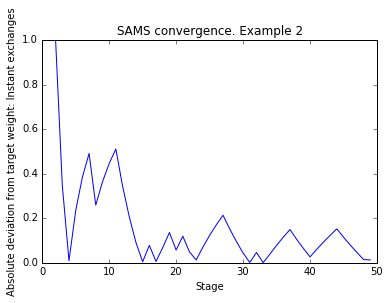

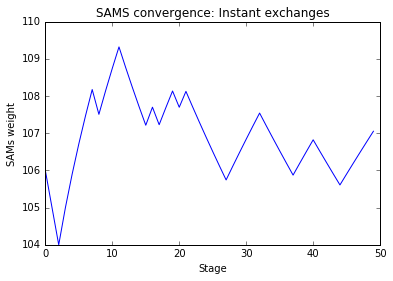

In [3]:
simulation, driver, sams_sampler, integrator = prepare_system('tyr_implicit.prmtop','tyr_implicit.inpcrd','tyr_implicit.cpin', 
                                                              platform='CPU', nsteps=0)
simulation.minimizeEnergy(maxIterations=1000)

# Initializing the weights for TYR with the approximately converged result.
g_initial = {'tyr':[  0.        ,  107.0]}
driver.import_gk_values(g_initial)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 50
for i in range(N):
    # MD/MC
    driver.compound_integrator.setCurrentIntegrator(0)
    driver.compound_integrator.step(10)
    driver.compound_integrator.setCurrentIntegrator(1)
    # SAMS adaptation
    sams_sampler.driver.update(simulation.context)  # protonation
    # Saving data
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', stage='burn-in', b=0.5, end_of_burnin=int(N/1.1)))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Stage')
plt.ylabel('Absolute deviation from target weight: Instant exchanges')
plt.title('SAMS convergence. Example 2')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Stage')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence: Instant exchanges')
plt.show()

### NCMC exchanges
The simulation of TYR in implicit solvent blows up. Printing out a of detail during NCMC to help explain the bug.

    Starting NCMC
('nitial energy', -78.444086041591)
('final energy', -78.444086041591)
('Work =', 0.0)
    Finished NCMC
    Starting NCMC
('nitial energy', -58.948667251180815)
('final energy', -165.04804543964823)
('Work =', -106.09937818846743)
    Finished NCMC
    Starting NCMC
('nitial energy', -179.12005284046288)
('final energy', -72.46275634120103)
('Work =', 106.65729649926185)
    Finished NCMC
    Starting NCMC
('nitial energy', -57.640310049754646)
('final energy', -165.44170896911137)
('Work =', -107.80139891935673)
    Finished NCMC
    Starting NCMC
('nitial energy', -166.94471918117878)
('final energy', -166.94471918117878)
('Work =', 0.0)
    Finished NCMC
    Starting NCMC
('nitial energy', -119.2595944251335)
('final energy', -119.2595944251335)
('Work =', 0.0)
    Finished NCMC
    Starting NCMC
('nitial energy', -90.23353399169429)
('final energy', 16.49219284529802)
('Work =', 106.72572683699231)
    Finished NCMC
    Starting NCMC
('nitial energy', -23.0273607

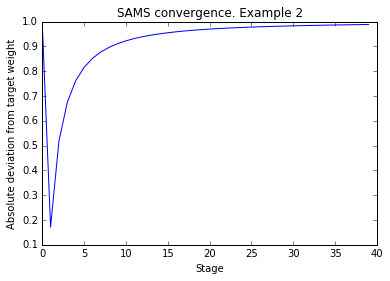

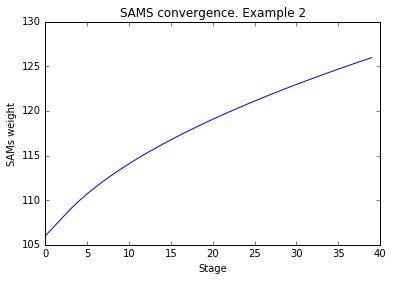

In [4]:
simulation, driver, sams_sampler, integrator = prepare_system('tyr_implicit.prmtop','tyr_implicit.inpcrd','tyr_implicit.cpin', 
                                                              platform='CPU', nsteps=1)
simulation.minimizeEnergy(maxIterations=1000)

# Initializing the weights for TYR with the approximately converged result.
g_initial = {'tyr':[  0.        ,  107.0]}
driver.import_gk_values(g_initial)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 40
for i in range(N):
    # MD/MC
    driver.compound_integrator.setCurrentIntegrator(0)
    driver.compound_integrator.step(10)
    driver.compound_integrator.setCurrentIntegrator(1)
    # SAMS adaptation
    sams_sampler.driver.update(simulation.context)  # protonation
    # Saving data
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', stage='burn-in', b=0.5, end_of_burnin=int(N/1.1)))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Stage')
plt.ylabel('Absolute deviation from target weight')
plt.title('SAMS convergence. Example 2')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Stage')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence. Example 2')
plt.show()

## Method 2. Calibration using `AmberCalibrationSystem`

In [5]:
def prepare_calibrator(prmtop, inpcrd, cpin, temperature=300.0*unit.kelvin, pH = 7.0, platform='CPU', nsteps=0, implicit=True):
    """
    Function to prepare an `AmberCalibrationSystem` from a system specified by AMBER topology files.

    Parameters
    ----------
    prmtop: str
        the name of the AMBER prmtop file
    inpcrd: str
        the name of the AMBER inpcrd file
    cpin: str
        the name of the AMBER cpin file
    pH: float
        the pH at which the calibration will be performed
    platform: str
        OpenMM platform with which the simulation will be performed. Choices are 'CPU' or 'OpenCL'
    nsteps: int
        The number of NCMC steps to perform for proton creation/annihilation. If nstesp=0, instant exchanges will be done.
    implicit: bool
        Whether to calibrated in implicit or explicit solvent

    Return
    ------
    calibration_system: protons.AmberCalibrationSystem
        The AmberCalibrationSystem object for the last residue in the topology
    """
    #### Reading in AMBER topologies system and initializing driver
    # The purpose of this section is to load the system to use it as the input for AmberCalibrationSystem
    prmtop = app.AmberPrmtopFile(prmtop)
    inpcrd = app.AmberInpcrdFile(inpcrd)
    positions = inpcrd.getPositions()
    topology = prmtop.topology
    # Create system
    if implicit == True:
        system = prmtop.createSystem(implicitSolvent=app.OBC2, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)
    else:
        system = prmtop.createSystem(nonbondedMethod=app.PME, constraints=app.HBonds)
    # Create protons integrator
    integrator = openmm.LangevinIntegrator(temperature, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    # Create protons proton driver
    driver = AmberProtonDrive(system, temperature, pH, prmtop, cpin, integrator, debug=False,
                              pressure=None, ncmc_steps_per_trial=nsteps, implicit=implicit)
    #### System loaded and driver initialized
    
    #### Section to initialize the SAMS calibration object
    # Create the calibration system
    resname_per_index, unique_residuenames = driver._detect_residues(AmberCalibrationSystem.supported_aminoacids)
    g_k = {key: None for (key) in unique_residuenames}
    
    calibration_settings = dict()
    calibration_settings["temperature"] = temperature
    # index 0 Should be the user integrator
    calibration_settings["timestep"] = driver.compound_integrator.getIntegrator(0).getStepSize()
    calibration_settings["pressure"] = driver.pressure
    calibration_settings["pH"] = driver.pH
    calibration_settings["solvent"] = driver.solvent
    calibration_settings["nsteps_per_trial"] = driver.nsteps_per_trial
    calibration_settings["platform_name"] = platform
    
    for residuename in unique_residuenames:
        # This sets up a system for calibration, with a SAMS sampler under the hood.
        calibration_system = AmberCalibrationSystem(residuename, calibration_settings, guess_free_energy=g_k[residuename], minimize=True)

    # For the purpose of this test function, only the last calibration object is returned.
    return calibration_system

To calibrate TYR, the following cell is based on the code found in the function in `AmberCalibrationSystem.sams_till_converged`. 

The below is an attempt to calibrate TYR in implicit solvent with instantanesous proton creation/annihilation.

In [6]:
run = False
if run == True:
    cal = prepare_calibrator('tyr_implicit.prmtop','tyr_implicit.inpcrd','tyr_implicit.cpin', nsteps=0)

    # Calibration counters
    gk_updates = 0
    iteration = 0

    # Update frequencies
    mc_every = 10
    gk_every = 1
    N = 3000

    # SAMS parameters
    scheme = 'binary'
    stage = "burn-in"
    end_of_burnin = int(N/1.7)
    b = 0.5

    # Output data
    weights = []
    deviation = []
    for i in range(N):
        # Regular MD
        cal.integrator.step(mc_every)
        iteration += 1

        # Attempt changing the protonation/tautomer state
        cal.sams_sampler.driver.update(cal.context)

        # Update gk using SAMS
        if iteration % gk_every == 0:
            target_deviation = cal.sams_sampler.adapt_zetas(cal.context, stage=stage, end_of_burnin=end_of_burnin, b=b, scheme=scheme)
            gk_updates += 1
            deviation.append(target_deviation)

            # We sample uniformly with SAMS, so we need to subtract log pi_j's from the g_k to get our targets.    
            g_k_uniform = cal.sams_sampler.get_gk()
            g_k = g_k_uniform - cal.log_state_probabilities
            weights.append(g_k)
            
    plt.plot(range(len(deviation)), deviation)
    plt.xlabel('Stage')
    plt.ylabel('Absolute deviation from target weight')
    plt.title('SAMS convergence. Example 1')
    plt.show()

    g_k = [w[1] for w in weights]
    plt.plot(range(len(g_k)), g_k)
    plt.xlabel('Stage')
    plt.ylabel('SAMs weight')
    plt.title('SAMS convergence. Example 1')
    plt.show()